In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from tqdm import tqdm

In [2]:
DATA_DIR ="AE_data/train/good"

file_list = os.listdir(DATA_DIR)
print(len(file_list))
file_list[:10]

941


['reshaped_part7_1870.jpg',
 'reshaped_part7_2179.jpg',
 'reshaped_part7_0845.jpg',
 'reshaped_part7_0762.jpg',
 'reshaped_part7_0734.jpg',
 'reshaped_part7_1689.jpg',
 'reshaped_part7_0143.jpg',
 'reshaped_part7_0871.jpg',
 'reshaped_part7_1898.jpg',
 'reshaped_part7_1820.jpg']

In [3]:
np.random.seed(7)
np.random.shuffle(file_list)
file_list[:10]

['reshaped_part7_0918.jpg',
 'reshaped_part7_1698.jpg',
 'reshaped_part7_0115.jpg',
 'reshaped_part7_0514.jpg',
 'reshaped_part7_1901.jpg',
 'reshaped_part7_0718.jpg',
 'reshaped_part7_1495.jpg',
 'reshaped_part7_1590.jpg',
 'reshaped_part7_0359.jpg',
 'reshaped_part7_0493.jpg']

In [4]:
X = []

for file in tqdm(file_list):
    path = os.path.join(DATA_DIR, file)
    #print(os.path.exists(path))
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
    X.append(img)

X = np.array(X)    

_, img_height, img_width, _ = X.shape

print(X.shape)

100%|██████████| 941/941 [00:01<00:00, 757.78it/s]


(941, 256, 256, 3)


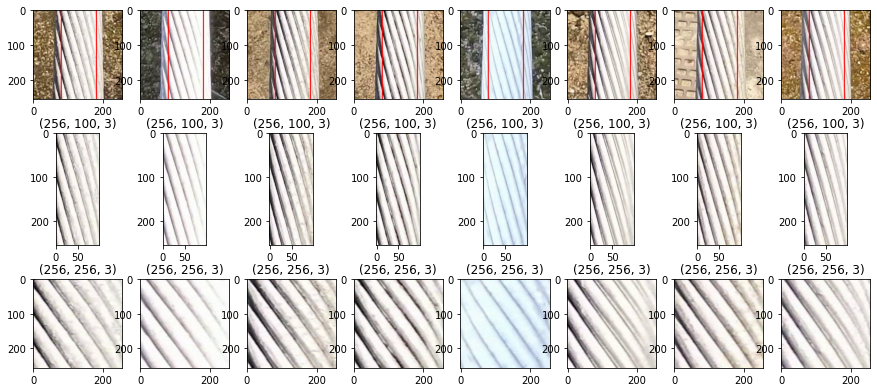

In [5]:
N = 8

LEFT = 80
RIGHT = 180

RED = (1,0,0)
BLUE = (0,0,1)


plt.figure(figsize=(15, 7))

for i in range(N):
    plt.subplot(3, N, i+1)
    img = X[i].copy()
    cv2.line(img, (LEFT, 0), (LEFT, img_height) , RED, 2)
    cv2.line(img, (RIGHT, 0), (RIGHT, img_height) , RED, 2)
    plt.imshow(img)
    plt.grid(False)
    
    plt.subplot(3, N, N+i+1)
    img = X[i].copy()
    img = img[:, LEFT:RIGHT, :]
    plt.imshow(img)
    plt.title(img.shape)
    plt.grid(False)    
    
    plt.subplot(3, N, 2*N+i+1)
    img_resized = cv2.resize(img, (img_height, img_width))
    plt.imshow(img_resized)
    plt.title(img_resized.shape)
    plt.grid(False)    

100%|██████████| 941/941 [00:00<00:00, 2176.70it/s]


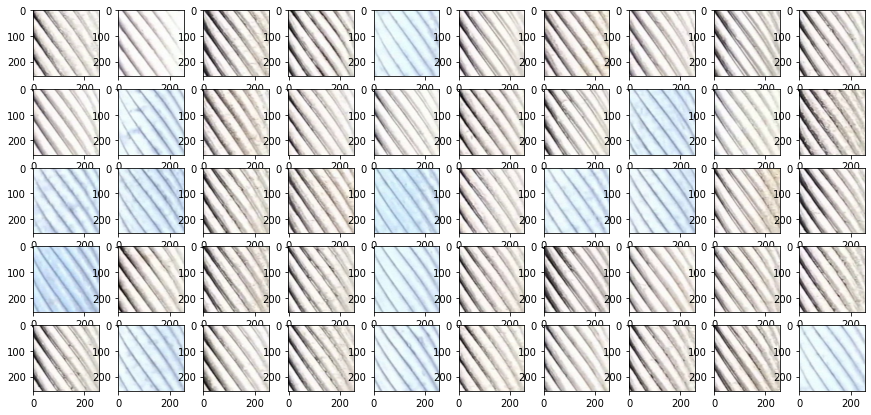

In [6]:
X_resized = []

for i in tqdm(range(X.shape[0])):
    img = X[i].copy()
    img = img[:, LEFT:RIGHT, :]
    img_resized = cv2.resize(img, (img_height, img_width))
    X_resized.append(img_resized)

X_resized = np.array(X_resized)

plt.figure(figsize=(15, 7))

for i in range(50):
    plt.subplot(5, 10, i+1)
    img = X_resized[i]
    plt.imshow(img)

In [7]:
print("=== X_resized ===")
print("Shape = ", X_resized.shape)
print("Max = ", X_resized.max())
print("Min = ", X_resized.min())

=== X_resized ===
Shape =  (941, 256, 256, 3)
Max =  1.0
Min =  0.0


In [8]:
from sklearn.model_selection import train_test_split
trainX, validX = train_test_split(X_resized, test_size=0.2, random_state=7)
print("trainX shape:", trainX.shape)
print("validX shape:", validX.shape)

trainX shape: (752, 256, 256, 3)
validX shape: (189, 256, 256, 3)


## Training

In [9]:
import tensorflow as tf
print("TF version:", tf.__version__)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers

TF version: 2.3.1


In [10]:
#mirrored_strategy = tf.distribute.MirroredStrategy()

In [11]:
#print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

### define model

In [56]:
input_dim = trainX.shape[1:]


autoencoder = Sequential(name="autoencoder")

#Encoder Layers
autoencoder.add(Conv2D(128, (3, 3), activation="relu", padding="same", input_shape=input_dim))
#autoencoder.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
autoencoder.add(MaxPooling2D((2, 2), padding="valid"))
autoencoder.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
#autoencoder.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
autoencoder.add(MaxPooling2D((2, 2), padding="valid"))
autoencoder.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
#autoencoder.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
autoencoder.add(MaxPooling2D((2, 2), padding="valid"))
autoencoder.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
#autoencoder.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
autoencoder.add(MaxPooling2D((2, 2), padding="valid"))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation="relu", padding="same"))
#autoencoder.add(Conv2D(8, (3, 3), activation="relu", padding="same"))
#autoencoder.add(MaxPooling2D((2, 2), padding="valid"))
#autoencoder.add(Conv2D(4, (3, 3), strides=(2,2), activation='relu', padding='same'))


#autoencoder.add(Conv2D(8, (2, 2), activation='relu', padding='valid'))

# Flatten encoding for visualization
#autoencoder.add(Flatten())
#autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
#autoencoder.add(UpSampling2D((2, 2)))
#autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
#autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
#autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
#autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
#autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
#autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
#autoencoder.add(Conv2D(3, (3, 3), activation='linear', padding='same'))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 32, 16)        

### compile

In [57]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")
#autoencoder.compile(optimizer="adam", loss="mse")

In [45]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >= 3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5

In [21]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      autoencoder.optimizer.lr.numpy()))

In [22]:
callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    #tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
    #                                   save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

#es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto', baseline=6.5e-04)
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0,mode='auto', baseline=6.5e-04)

### compile and train

In [58]:
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy")
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")
#autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(
                trainX, trainX,
                epochs = 50,
                batch_size=32,
                shuffle = True,
                validation_data=(validX, validX),
                #validation_split=0.2,
                #callbacks=[callbacks, es_cb],
                #callbacks=callbacks,
                verbose=1
               )

Epoch 1/50
24/24 [==============================] - 5s 214ms/step - loss: 0.4705 - val_loss: 0.4431
Epoch 2/50
24/24 [==============================] - 5s 206ms/step - loss: 0.4307 - val_loss: 0.4303
Epoch 3/50
24/24 [==============================] - 5s 205ms/step - loss: 0.4070 - val_loss: 0.3860
Epoch 4/50
24/24 [==============================] - 5s 209ms/step - loss: 0.3721 - val_loss: 0.3659
Epoch 5/50
24/24 [==============================] - 5s 206ms/step - loss: 0.3604 - val_loss: 0.3609
Epoch 6/50
24/24 [==============================] - 5s 206ms/step - loss: 0.3577 - val_loss: 0.3596
Epoch 7/50
24/24 [==============================] - 5s 205ms/step - loss: 0.3556 - val_loss: 0.3576
Epoch 8/50
24/24 [==============================] - 5s 204ms/step - loss: 0.3539 - val_loss: 0.3560
Epoch 9/50
24/24 [==============================] - 5s 205ms/step - loss: 0.3531 - val_loss: 0.3547
Epoch 10/50
24/24 [==============================] - 5s 205ms/step - loss: 0.3519 - val_loss: 0.3560

### plot history

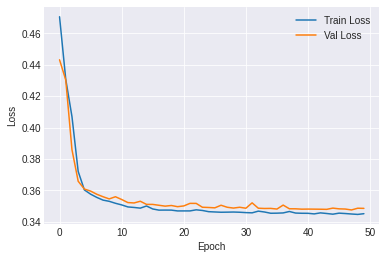

In [59]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']), label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val Loss')
plt.legend()

### save the trained model

In [64]:
from datetime import datetime

now = datetime.now()
now_str = now.strftime("%Y%m%d_%H%M")

MODEL_DIR = "trained_models"
model_name = "autoencoder_{}.h5".format(now_str)
model_path = os.path.join(MODEL_DIR, model_name)

autoencoder.save(model_path)
print(model_path)

trained_models/autoencoder_20210308_1839.h5


### check trained models

In [3]:
MODEL_DIR = "trained_models"
sorted(os.listdir(MODEL_DIR))

['autoencoder_20210105_0943.h5', 'autoencoder_20210308_1553.h5']

In [63]:
import requests
token = "yIhxfOhyl7x7fzvCkLYgUD5VorcAcjsLrt9R7n6id0K"
url = "https://notify-api.line.me/api/notify"
headers = {"Authorization": "Bearer " + token}
payload = {"message": "学習完了！"}
requests.post(url, headers=headers, data=payload)

<Response [200]>

In [6]:
model_name ="autoencoder_20210308_1553.h5"
model_path = os.path.join(MODEL_DIR, model_name)
autoencoder = tf.keras.models.load_model(model_path)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 128, 128, 64)      73792     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 32)        

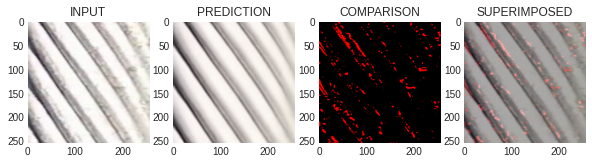

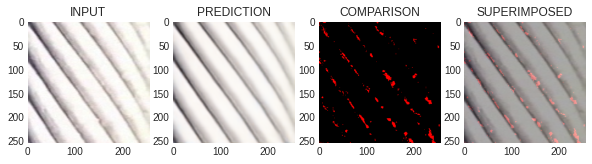

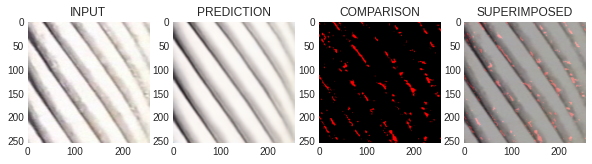

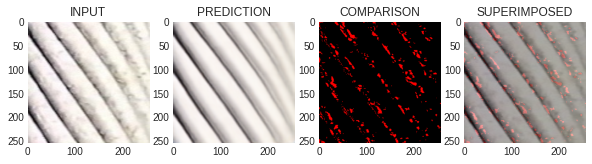

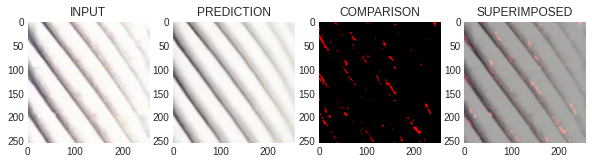

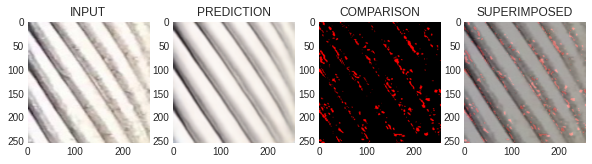

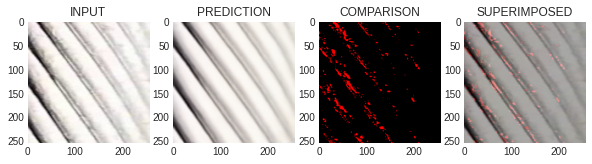

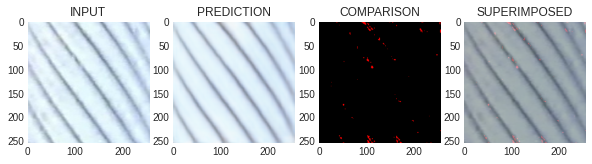

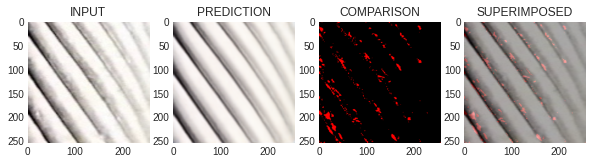

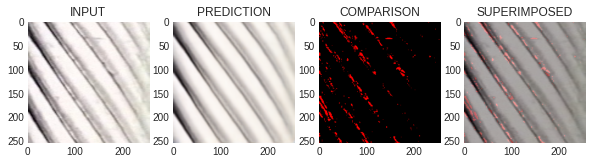

In [66]:
thresh = 0.10

for i in range(10):
    #i = 5

    input_img = trainX[i]
    pred_img = autoencoder.predict(np.expand_dims(input_img, 0))[0]
    sub_img = np.abs(input_img-pred_img)

    sub_img[sub_img>thresh]=1
    sub_img[sub_img<=thresh]=0

    sub_img = sub_img.sum(axis=2)
    sub_img[sub_img>=1]=255

    mask = np.zeros(input_img.shape, dtype=np.uint8)
    mask[:,:,0]=sub_img

    superimposed_img = mask*0.5 + input_img*255
    superimposed_img = superimposed_img/np.max(superimposed_img)


    plt.figure(figsize=(10,4))

    plt.subplot(1, 4, 1)
    plt.imshow(input_img)
    plt.title("INPUT")
    plt.grid(False)

    plt.subplot(1, 4, 2)
    plt.imshow(pred_img)
    plt.title("PREDICTION")
    plt.grid(False)

    plt.subplot(1, 4, 3)
    plt.imshow(mask)
    plt.title("COMPARISON")
    plt.grid(False)

    plt.subplot(1, 4, 4)
    plt.imshow(superimposed_img)
    plt.title("SUPERIMPOSED")
    plt.grid(False)

    plt.savefig(f"test_{i}.png")